<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

Загрузим и посмотрим на данные. Сразу изменим тип данных datetime с object на datetime64 и установим индекс таблицы равным столбцу datetime

In [2]:
ds = pd.read_csv('/datasets/taxi.csv', parse_dates =[0],index_col= 0)
display(ds.head())
display(ds.tail())
ds.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

Проверим, в хронологическом ли порядке расположены даты и время, используем для этого атрибут индекса таблицы is_monotonic.

In [3]:
ds.index.is_monotonic

True

Данные отсортированы в хронологическом порядке. Попробуем взглянуть на них на графике.

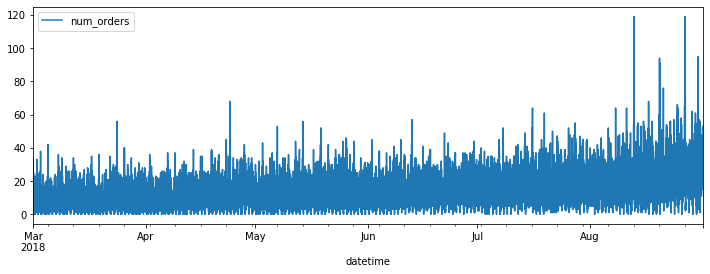

In [4]:
ds.plot(figsize = (12,4))

По графику пока только видно, что похоже количество заказов подрастает. 
Данные измерены с периодичностью 10 минут, выполним их ресемплирование по одному часу.

In [5]:
ds = ds.resample('1H').sum()
ds.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


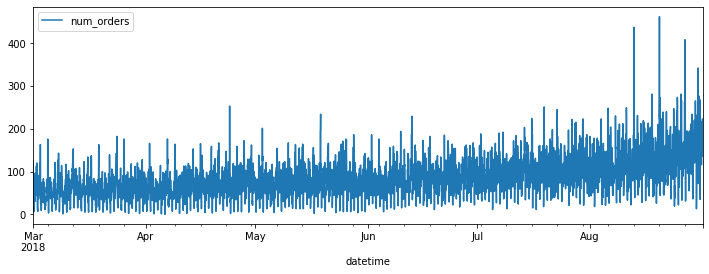

In [6]:
ds.plot(figsize = (12,4))

Разложим временной ряд на тренд и сезонную компоненту.

Функция для разложения и построения графиков:

In [7]:
def decompose_plot(data):
    decomposed = seasonal_decompose(data)

    plt.figure(figsize=(10, 10))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca()) 
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca()) 
    plt.title('Residuals')
    plt.tight_layout()

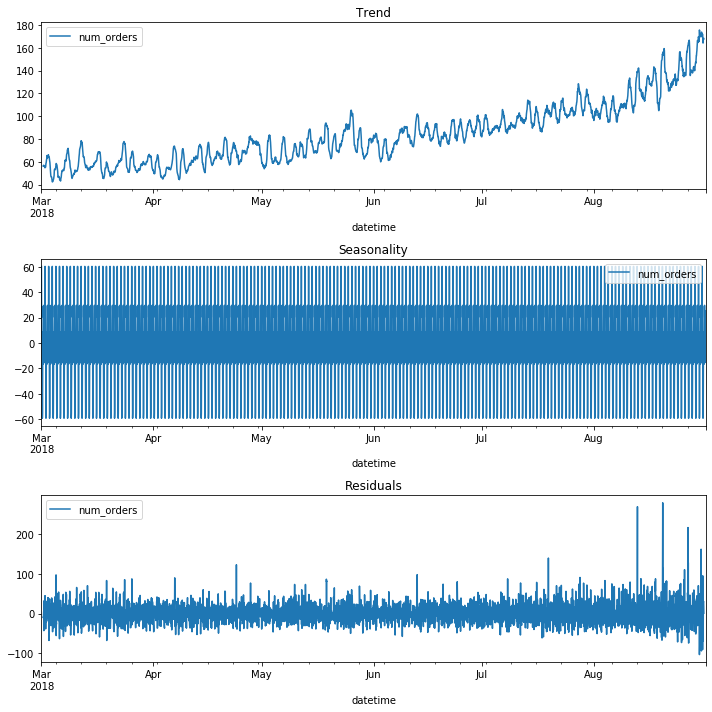

In [8]:
decompose_plot(ds)

Посмотрим тренд и сезонность за месяц и неделю

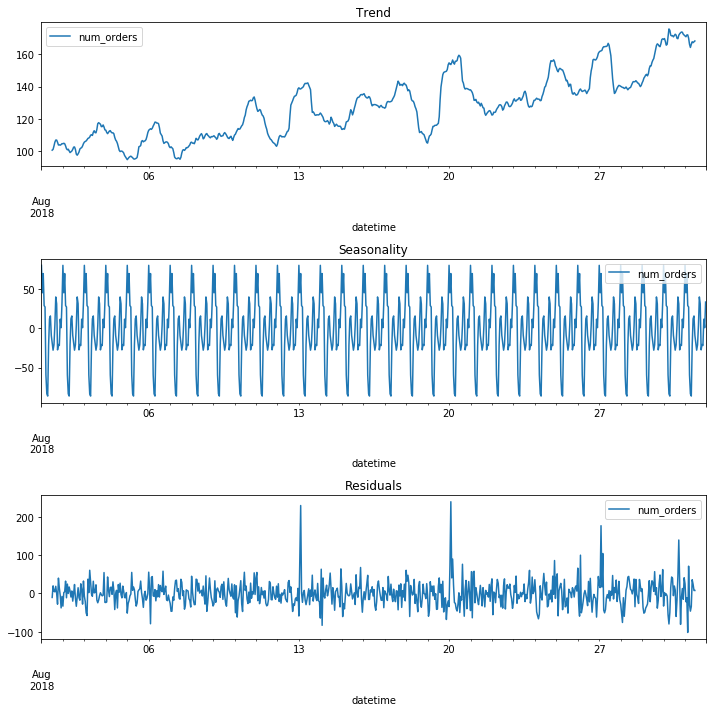

In [9]:
decompose_plot(ds['2018-08-01':'2018-08-31'])

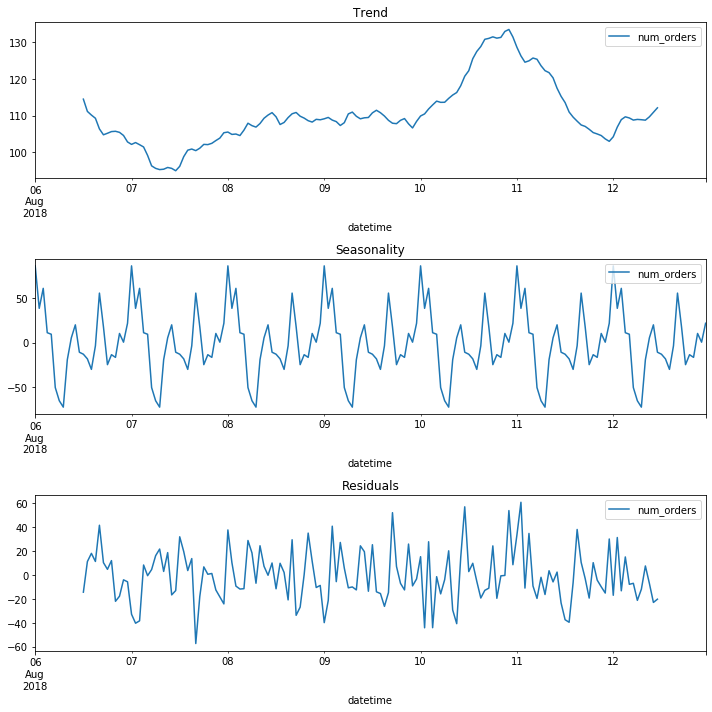

In [10]:
decompose_plot(ds['2018-08-06':'2018-08-12'])

И еще детальнее посмотрим на поведение ряда в пределах 2-х суток

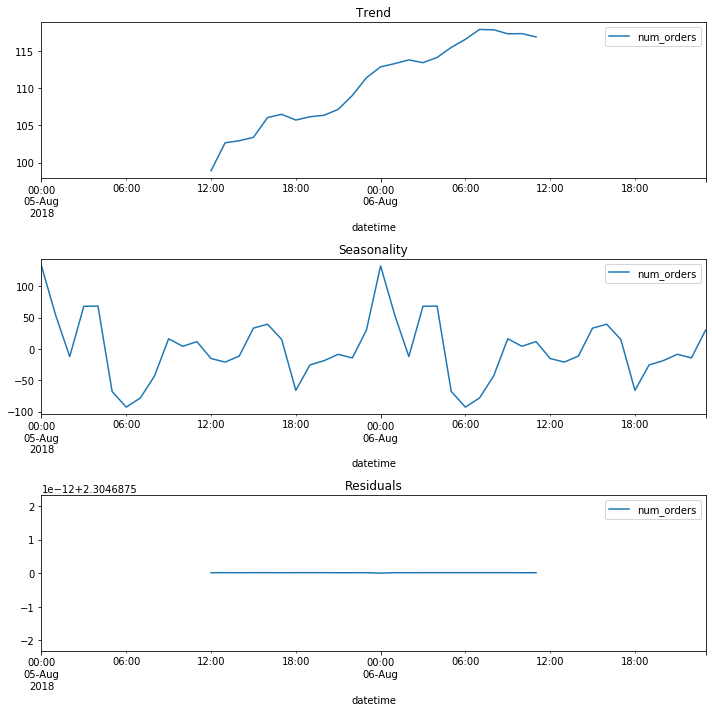

In [11]:
decompose_plot(ds['2018-08-05':'2018-08-06'])

Ряд не похож на стационарный, наблюдается тренд к росту. Также отмечается суточная сезонность.
Проверим ряд на стацонарность с помощью расширенного теста Дикки-Фуллера. 

In [12]:
result = adfuller(ds['num_orders'], regression='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.891452
p-value:  4.054939789240617e-17
Critical Values:
	1%: -4.374
	5%: -3.834
	10%: -3.554


Видно, что значение теста гипотезы -10.891452 меньше 1%, поэтому исходная гипотеза что ряд не стационарный может быть отвергнута, p-value также мало. Будем считать ряд достаточно стационарным.

## Обучение

Создадим дополнительные признаки для обучения моделей. Так как у нас наблюдаются дневные и недельные сезонности, добавим признаки 'hour', 'day', 'dayofweek'. Также добавим lag features - они подскажут, будет ли функция x(t) расти или уменьшаться. И также добавим скользящее среднее - оно как признак будет задавать общий тренд временного ряда.

Для создания признаков сделаем отдельную функцию.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Добавим признаки. Наиболее заметные регулярные колебания частоты заказов присходят в течение суток, установим значение max_lag равным 1 и rolling_mean_size - 24.

In [14]:
make_features(ds, 1, 24)
display(ds.tail())

,num_orders,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,
2018-08-31 19:00:00,136,19,4,207.0,164.875000
2018-08-31 20:00:00,154,20,4,136.0,167.541667
2018-08-31 21:00:00,159,21,4,154.0,168.041667
2018-08-31 22:00:00,223,22,4,159.0,166.416667
2018-08-31 23:00:00,205,23,4,223.0,169.125000


Разделим данные на обучающую и тестовую (10% от исходных данных) выборки

In [15]:
train, test = train_test_split(ds, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

print(features_train.shape)
print(target_train.shape)
print(train.index.min(), train.index.max())
print()

print(features_test.shape)
print(target_test.shape)
print(test.index.min(), test.index.max())

(3950, 4)
(3950,)
2018-03-02 00:00:00 2018-08-13 13:00:00

(442, 4)
(442,)
2018-08-13 14:00:00 2018-08-31 23:00:00


## Тестирование

In [16]:
#Функция построения графиков сравнения точности предсказания
def comparison_plot(model_name, features_test, target_test, target_predict):
    
    plt.figure(figsize=(16, 6))
    plt.title('Распределение реальных и предсказанных значений, модель ' + model_name)
    plt.ylabel('Заказы')
    plt.plot(features_test.index, target_test, label='Реальные', color='silver')
    plt.plot(features_test.index, target_predict, label='Предсказанные', color='red')
    plt.legend()
    plt.grid()
    plt.show()

Создадим сводную таблицу для сравнения результатов работы алгоритмов.

In [17]:
model_comparison = pd.DataFrame(columns=['Алгоритм', 'RMSE на валидации'])
display(model_comparison)

,Алгоритм,RMSE на валидации


Обучим разные модели с подбором гиперпараметров и проверим их работу на тестовой выборке. Первой попробуем линейную регрессию.

RMSE обучающей выборки: 30.907
RMSE тестовой выборки:  51.194



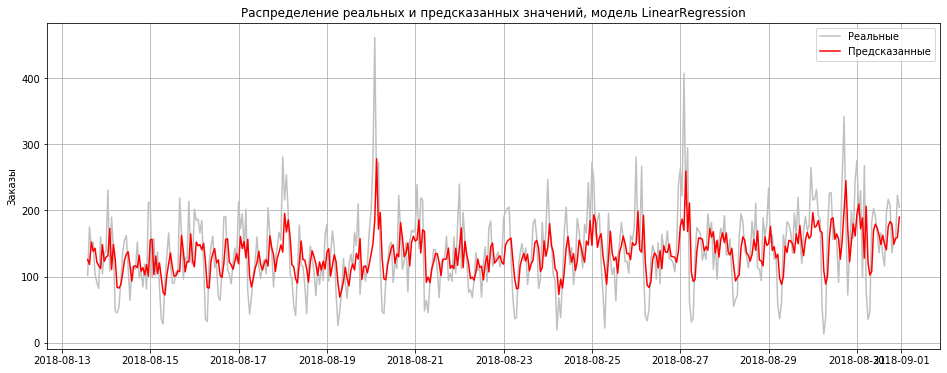

,Алгоритм,RMSE на валидации
0,LinearRegression,51.194


In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict_test = model.predict(features_test)
target_predict_train = model.predict(features_train)

rmse_train = mean_squared_error(target_train, target_predict_train) ** 0.5
rmse_test = mean_squared_error(target_test, target_predict_test) ** 0.5

print("RMSE обучающей выборки:", round(rmse_train, 3))
print("RMSE тестовой выборки: ", round(rmse_test, 3))
print()

comparison_plot('LinearRegression', features_test, target_test, target_predict_test)

result = {'Алгоритм' : 'LinearRegression',
              'RMSE на валидации' : round(rmse_test, 3)}
model_comparison = model_comparison.append(result, ignore_index=True)
model_comparison

Функция для настройки и тестирования алгоритмов

In [19]:
def  tuning_test_models(model_name, model, parameters, features, target, features_test, target_test):
    
    cv = TimeSeriesSplit(n_splits=8)
    
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
    grid.fit(features, target)
 
    best_model = grid.best_estimator_    
    best_model.fit(features, target)   
    target_predict = best_model.predict(features_test)
    
    rmse = mean_squared_error(target_test, target_predict) ** 0.5
    
    print("\n========================================================")
    print(" Модель",  model_name)
    print("========================================================")
    
    print("\n Лучший результат на обучении:\n",
          (grid.best_score_ * (-1))** 0.5)
    
    print("\n Лучшие параметры модели:\n",
          grid.best_params_)
    
    print("\n ========================================================")
        
    print("\n RMSE на валидации:\n", round(rmse, 3))
    print("\n ========================================================")
    print()
    
    comparison_plot(model_name, features_test, target_test, target_predict)
    
    result = {'Алгоритм' : model_name,
              'RMSE на валидации' : round(rmse, 3)}
    
    return result


 Модель LGBMRegressor

 Лучший результат на обучении:
 24.837288647608975

 Лучшие параметры модели:
 {'learning_rate': 0.05, 'n_estimators': 150}


 RMSE на валидации:
 43.564




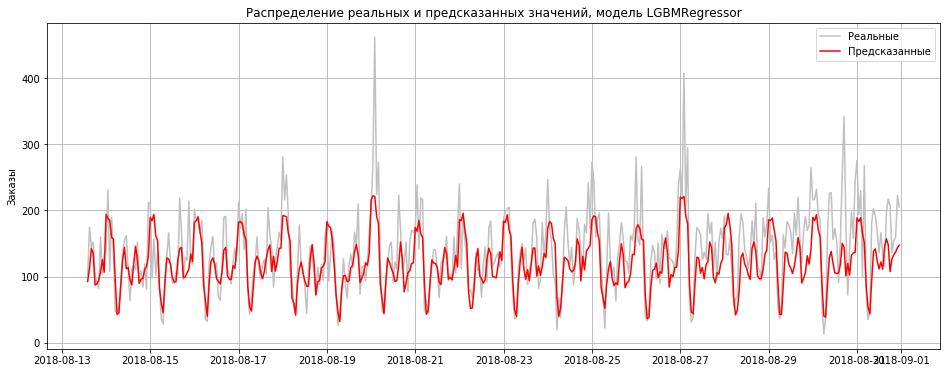

,Алгоритм,RMSE на валидации
0,LinearRegression,51.194
1,LGBMRegressor,43.564


CPU times: user 39.5 s, sys: 542 ms, total: 40 s
Wall time: 40.6 s


In [20]:
%%time
model_results = tuning_test_models('LGBMRegressor', 
                                  LGBMRegressor(random_state=12345), 
                                  {'n_estimators' : [150, 200], 'learning_rate' : [0.05, 0.1]}, 
                                  features_train, 
                                  target_train,
                                  features_test, 
                                  target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)

0:	learn: 27.8655263	total: 47.3ms	remaining: 7.05s
10:	learn: 20.6828044	total: 52.3ms	remaining: 660ms
20:	learn: 18.2700559	total: 60.2ms	remaining: 370ms
30:	learn: 17.1295692	total: 98.8ms	remaining: 379ms
40:	learn: 16.2592949	total: 104ms	remaining: 275ms
50:	learn: 15.5229109	total: 191ms	remaining: 371ms
60:	learn: 14.9695088	total: 195ms	remaining: 284ms
70:	learn: 14.4658626	total: 199ms	remaining: 221ms
80:	learn: 13.9021348	total: 285ms	remaining: 243ms
90:	learn: 13.4601958	total: 290ms	remaining: 188ms
100:	learn: 13.0777704	total: 296ms	remaining: 143ms
110:	learn: 12.7232999	total: 300ms	remaining: 105ms
120:	learn: 12.3412689	total: 304ms	remaining: 72.9ms
130:	learn: 12.0993321	total: 308ms	remaining: 44.7ms
140:	learn: 11.8402329	total: 399ms	remaining: 25.5ms
149:	learn: 11.5792730	total: 403ms	remaining: 0us
0:	learn: 28.0568052	total: 733us	remaining: 109ms
10:	learn: 21.8268572	total: 5.29ms	remaining: 66.8ms
20:	learn: 19.5339438	total: 27.6ms	remaining: 170ms


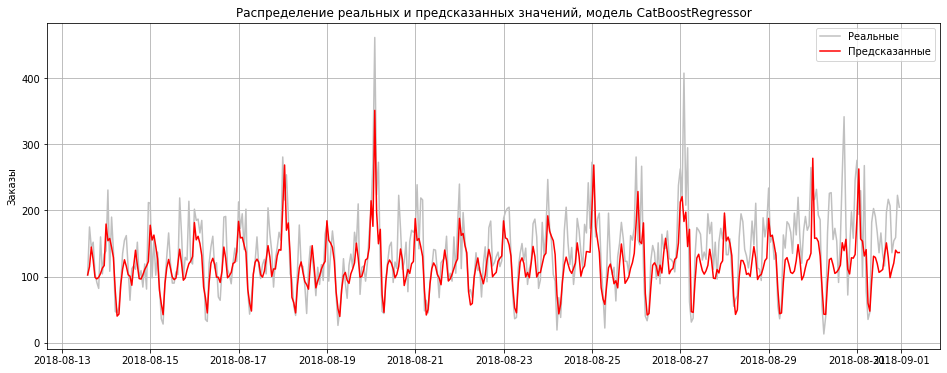

,Алгоритм,RMSE на валидации
0,LinearRegression,51.194
1,LGBMRegressor,43.564
2,CatBoostRegressor,44.814


CPU times: user 31.2 s, sys: 3.72 s, total: 34.9 s
Wall time: 50.9 s


In [21]:
%%time
model_results = tuning_test_models('CatBoostRegressor', 
                                  CatBoostRegressor(random_state=12345, verbose=10, iterations=150), 
                                  {'depth' : [5, 10], 'learning_rate' : [0.1]}, 
                                  features_train, 
                                  target_train,
                                  features_test, 
                                  target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)


 Модель RandomForestRegressor

 Лучший результат на обучении:
 25.020892704973605

 Лучшие параметры модели:
 {'max_depth': 24}


 RMSE на валидации:
 45.437




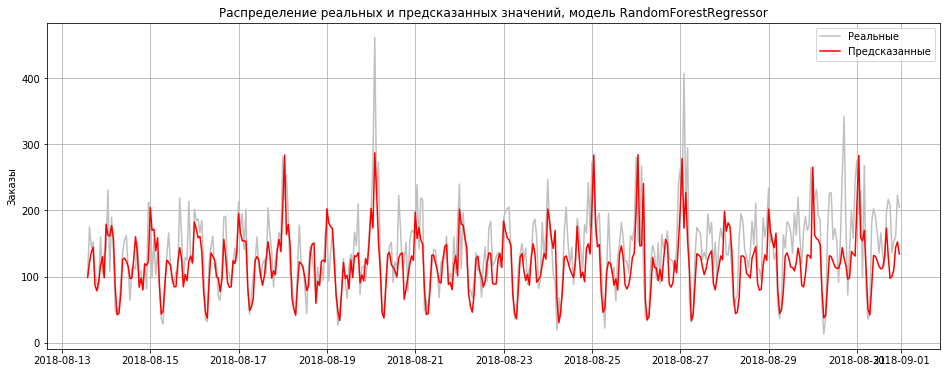

,Алгоритм,RMSE на валидации
0,LinearRegression,51.194
1,LGBMRegressor,43.564
2,CatBoostRegressor,44.814
3,RandomForestRegressor,45.437


CPU times: user 8.04 s, sys: 29.4 ms, total: 8.07 s
Wall time: 8.19 s


In [22]:
%%time
model_results = tuning_test_models('RandomForestRegressor', 
                                  RandomForestRegressor(random_state=12345, n_estimators=100), 
                                  {'max_depth' : [18, 24]}, 
                                  features_train, 
                                  target_train,
                                  features_test, 
                                  target_test)

model_comparison = model_comparison.append(model_results, ignore_index=True)
display(model_comparison)

Почти все протестированне модели продемонстрировали RMSE на тестовой выборке не более 48. Что и требовалось по условию задания. Лучший результат показала модель LGBMRegressor - 43.564

## Выводы

В результате выполнения данного проекта были построены модели для прогнозирования количество заказов такси на следующий час. Для этого были проведены анализ и подготовка временного ряда данных о заказах такси в аэропортах. Различными методами, с подбором гиперпараметров, были обучены разные модели и протестирована их работа. Почти все протестированне модели показали метрику RMSE на тестовой выборке не более 48. Лучший результат у модели LGBMRegressor. 